In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import matplotlib.pyplot as plt
import keras
import re
import nltk
import string
import json
from time import time
import pickle
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout
from keras.layers.merge import add

For using Resnet50, we need to resize the images to (224,224), the current size is (150,150). First we will define the preprocess image function

In [7]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


We will use pretrained Resnet50 Model, we will load the model and remove the last softmax layer since we need to extract features from images

In [8]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

2022-05-18 13:28:18.893533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 13:28:19.038990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 13:28:19.039931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 13:28:19.041383: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [9]:
model_new = Model(model.input, model.layers[-2].output)

Function for extracting features from Image using the above model

In [10]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

The preprocessed images will be sent to Resnet50 Model for feature extraction

In [11]:

path="seg_train/seg_train"
image_names=[]
feature_vec=[]
actual_class=[]
i=0
j=0
for file_name in os.listdir(path):
    sub_dir_path = path + '/' + file_name
    for image_name in os.listdir(sub_dir_path):
        #print(image_name)
        img=image_name
        feature_vec.append(encode_image(sub_dir_path+'/'+img))
        image_names.append(img)
        actual_class.append(i)
        if j%100==0:
            print("Encoding image")
            print(j)
        j+=1
    
    i+=1
        
    

    
        
        
        
#     return features,img_name
# path="../input/intel-image-classification/"
# imagedeatures

2022-05-18 13:28:24.264924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-18 13:28:26.287633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Encoding image
0
Encoding image
100
Encoding image
200
Encoding image
300
Encoding image
400
Encoding image
500
Encoding image
600
Encoding image
700
Encoding image
800
Encoding image
900
Encoding image
1000
Encoding image
1100
Encoding image
1200
Encoding image
1300
Encoding image
1400
Encoding image
1500
Encoding image
1600
Encoding image
1700
Encoding image
1800
Encoding image
1900
Encoding image
2000
Encoding image
2100
Encoding image
2200
Encoding image
2300
Encoding image
2400
Encoding image
2500
Encoding image
2600
Encoding image
2700
Encoding image
2800
Encoding image
2900
Encoding image
3000
Encoding image
3100
Encoding image
3200
Encoding image
3300
Encoding image
3400
Encoding image
3500
Encoding image
3600
Encoding image
3700
Encoding image
3800
Encoding image
3900
Encoding image
4000
Encoding image
4100
Encoding image
4200
Encoding image
4300
Encoding image
4400
Encoding image
4500
Encoding image
4600
Encoding image
4700
Encoding image
4800
Encoding image
4900
Encoding ima

On the feature vector we extracted from pretrained CNN model, we will apply Kmeans clustering algorithm:

In [12]:
from sklearn.cluster import KMeans
k = 6
clusters = KMeans(k, random_state = 40)
clusters.fit(feature_vec)


KMeans(n_clusters=6, random_state=40)

In [13]:
image_cluster = pd.DataFrame(image_names,columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster.head()

,image,clusterid
0,14986.jpg,0
1,3138.jpg,4
2,1700.jpg,4
3,16257.jpg,4
4,2863.jpg,4


From the original dataset we are making a dictionary of different clusters (class num mapped with image name)

In [14]:
actual_map={}
for i in range(len(image_names)):
    if(actual_class[i] in actual_map.keys()):
        actual_map[actual_class[i]].append(image_names[i])
    else:
        actual_map[actual_class[i]]=[]
        actual_map[actual_class[i]].append(image_names[i])

We need to make a dictionary of our predicted classed as keys with image names as values:

In [15]:
predicted_class={}
for i in range(0,len(image_names)):
    key=image_cluster.iloc[i]['clusterid']
    if key in predicted_class.keys():
        predicted_class[key].append(image_cluster.iloc[i]["image"])
    else:
        predicted_class[image_cluster.iloc[i]["clusterid"]]=[]
        predicted_class[image_cluster.iloc[i]["clusterid"]].append(image_cluster.iloc[i]["image"])

For evaluation metrics, we are using "Purity" whose function I have implemented myself below:

In [16]:
rowsum=0
for i in range(0,6):
    rowmax=0
    for j in range(0,6):
        true_pred=0
        for num in predicted_class[i]:
             if(num in actual_map[j]):
                 true_pred+=1
        rowmax=max(rowmax,true_pred)
    rowsum+=rowmax
purity=rowsum/len(image_names)
purity
            

0.8867749750605672

Calculating Adjusted Rand Index

In [17]:
from sklearn.metrics.cluster import adjusted_rand_score
actual_class_list=[]
for img in image_cluster['image']:
    for classnum in actual_map.keys():
        if img in actual_map[classnum]:
            actual_class_list.append(classnum)

            
predicted_class_list=image_cluster['clusterid']

ari=adjusted_rand_score(actual_class_list, predicted_class_list)
ari

0.7619636790273444

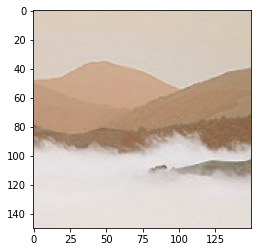

cluster 0


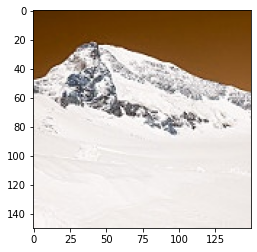

cluster 0


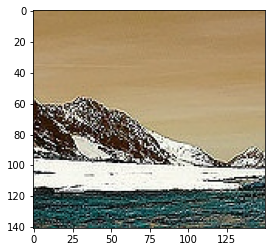

cluster 0


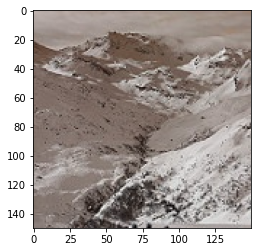

cluster 0


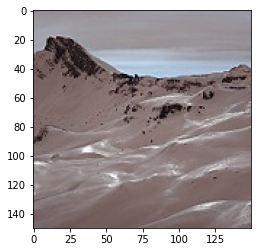

cluster 0


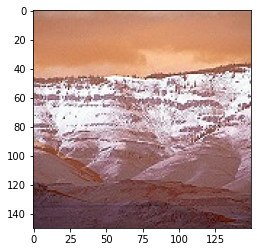

cluster 0


In [31]:
path="seg_train/seg_train"
#Printing 6 images of cluster '0'
imgs=predicted_class[0]
imgs=imgs[0:6]
for img in imgs:
        for file_name in os.listdir(path):
            sub_dir_path = path + '/' + file_name
            if img in os.listdir(sub_dir_path):
                img1=cv2.imread(sub_dir_path+'/'+img)
                plt.imshow(img1)
                plt.show()
                print("cluster 0")

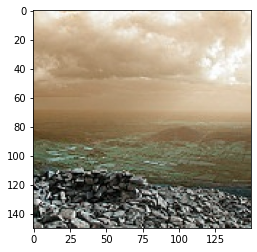

cluster 3


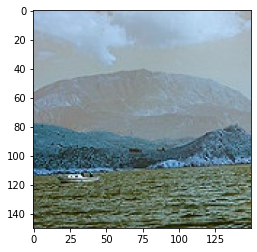

cluster 3


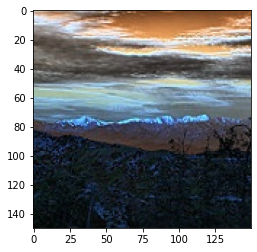

cluster 3


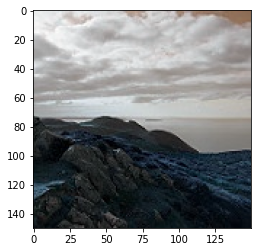

cluster 3


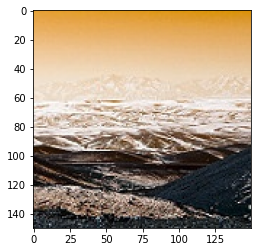

cluster 3


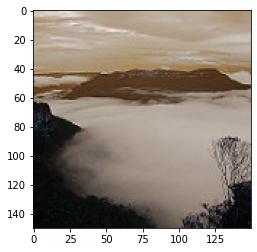

cluster 3


In [30]:
path="seg_train/seg_train"
#Printing 6 images of cluster '3'
imgs=predicted_class[3]
imgs=imgs[0:6]
for img in imgs:
        for file_name in os.listdir(path):
            sub_dir_path = path + '/' + file_name
            if img in os.listdir(sub_dir_path):
                img1=cv2.imread(sub_dir_path+'/'+img)
                plt.imshow(img1)
                plt.show()
                print("cluster 3")